In [92]:
# note: fdfdpy_OO must be in your JUPYTER_PATH for this import to work (or you can manually add it to path with some google=able code.)
from fdfdpy.Fdfd import Fdfd
from nonlinear_solvers import born_solve, newton_solve

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
omega = 5e14                # angular frequency (2pi)
dl = 0.04                   # grid size L0
eps_r = np.ones((100,100))  # relative permittivity
eps_r[40:60, 40:60] = 5     # define box
NPML = [10, 10]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')

In [94]:
# sets simulation variables, constructs system matrix 'A', stored in 'simulation' object
simulation = Fdfd(omega,eps_r,dl,NPML,pol)

In [95]:
# set source and solve for electromagnetic fields
b = np.zeros((simulation.Nx,simulation.Ny))
b[40:60,30] = 100
(Hx,Hy,Ez) = simulation.solve_fields(b)

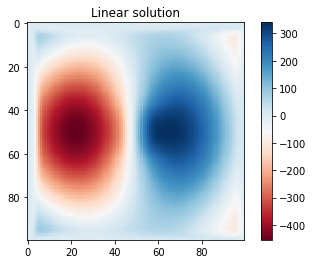

In [96]:
# plot
plt.imshow(np.real(Ez), cmap='RdBu')
plt.colorbar()
plt.title('Linear solution')
plt.show()

In [97]:
chi3 = 2.8*1e-18         # Silcion in m^2/V^2 from Boyd's book
chi3_fdfd = chi3/simulation.L0**2        # In the units of the FDFD solver such that eps_nl = eps_r + 3*chi3_fdfd*|e|^2
nl_region = np.zeros(eps_r.shape)  # Nonliearity region
nl_region[40:60, 40:60] = 1
# Define nonlinear function
kerr_nonlinearity = lambda e: 3*chi3_fdfd*np.square(np.abs(e))
# Define the partial derivative of the nonlinear function w.r.t. e
kerr_nl_de = lambda e: 3*chi3_fdfd*np.conj(e)

In [109]:
# Do a born solve for the nonlinear fields
simulation = Fdfd(omega,eps_r,dl,NPML,pol)
(Ez_nl_B, convergence_array) = born_solve(simulation, eps_r, b, kerr_nonlinearity, nl_region, Ez_nl_B, 
                                        conv_threshold=1e-10, max_num_iter=20)

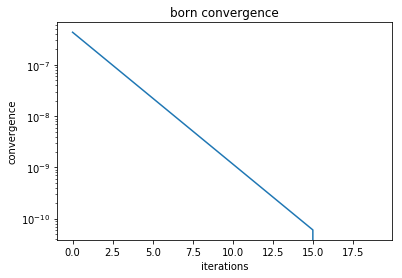

In [110]:
plt.plot(convergence_array)
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('convergence')
plt.title('born convergence')
plt.show()

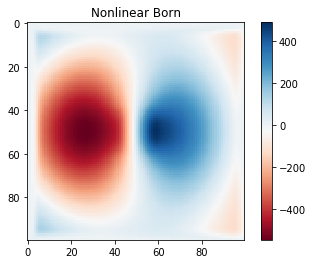

In [100]:
# plot
plt.imshow(np.real(Ez_nl_B), cmap='RdBu')
plt.colorbar()
plt.title('Nonlinear Born')
plt.show()

In [102]:
# Do a newton solve for the nonlinear fields
simulation = Fdfd(omega,eps_r,dl,NPML,pol)
(Ez_nl_N, convergence_array) = newton_solve(simulation, eps_r, b, kerr_nonlinearity, kerr_nl_de, nl_region, conv_threshold=1e-10, max_num_iter=20)

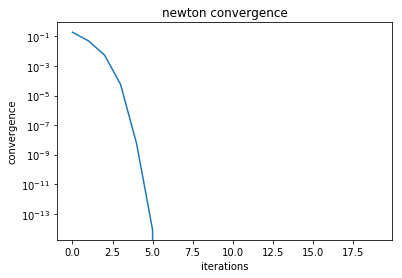

In [103]:
plt.plot(convergence_array)
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('convergence')
plt.title('newton convergence')
plt.show()

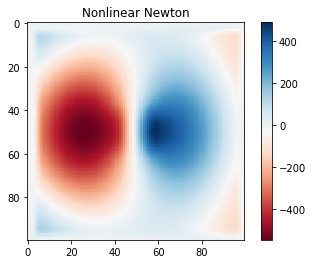

In [104]:
# plot
plt.imshow(np.real(Ez_nl_N), cmap='RdBu')
plt.colorbar()
plt.title('Nonlinear Newton')
plt.show()

In [81]:
print(np.linalg.norm(Ez_nl_B - Ez_nl_N))

0.025695907770204852
